In [63]:
#this macro read test data, use the trained gnn that you choose to select good hit per events.
#then print some images and root file with filtered data.

In [1]:
import torch
import torch_geometric
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import MyData as data
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
from torch_geometric.loader import DataLoader
import ROOT
import numpy as np
from matplotlib.lines import Line2D
import pandas as pd
import array as ary
import GNN_model

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  x86_64-conda_cos6-linux-gnu-c++  -O3 -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.20/02


In [2]:
sel_alg=1
view='xz'

In [3]:
if sel_alg==1:
    num_ly=10
    lr=0.0001
    num_to_reduce=64
    hidden_size = num_to_reduce*num_ly

In [4]:
# condition='HNoise'
# condition='norm'
condition='norm_balanced'
# condition ='normal_env'

In [5]:
if sel_alg==3:
    num_ly=3
    num_to_reduce=64
    hidden_size = num_to_reduce*num_ly

In [6]:
model_list=['SageConv','SageConv2','GCN','GCN_2','GAT','GDPModel']

In [7]:
NUM_FEATURES=5
NUM_CLASSES=1

In [8]:
if sel_alg>len(model_list):
    print('no algorithm available')
if sel_alg==0:
    model = GNN_model.SageConv(num_feat=NUM_FEATURES,num_class=NUM_CLASSES)
elif sel_alg==1:
    model = GNN_model.SageConv2(hidden_size=hidden_size, num_ly=num_ly, num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==2:
    model = GNN_model.GCN(num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==3:
    model = GNN_model.GCN_2(hidden_size=hidden_size, num_ly=num_ly, num_feat=NUM_FEATURES, num_class=NUM_CLASSES,num_to_reduce=64)
elif sel_alg==4:
    model = GNN_model.GAT(num_feat=NUM_FEATURES, num_class=NUM_CLASSES)
elif sel_alg==5:
    model = GNN_model.GDPModel()

In [9]:
data=data.dataset_preparation(root='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed/')

if view=='xz':
    fname='pi-_10GeV_4ly_1e-4ly_normalized_1e-4_viewx' #norm
    # fname='pi-_10GeV_4ly_1e-4_inclined_NEW_viewx'
    # fname='pi-_10GeV_4ly_1e-4_inclined_4ly_GAT_viewx'#gat data
    # fname='pi-_10GeV_4ly_3e-4_inclined_NEW_viewx' #HNoise
     # fname= "pi-_10GeV_4ly_3e-4ly_normalized_viewx" #norm hnoise
       
else:
    fname='pi-_10GeV_4ly_1e-4ly_normalized_1e-4_viewy' #norm
    # fname='pi-_10GeV_4ly_1e-4_inclined_NEW_viewy'
    # fname='pi-_10GeV_4ly_1e-4_inclined_4ly_GAT_viewy'#gat data
    # fname='pi-_10GeV_4ly_3e-4_inclined_NEW_viewy' #HNoise
    # fname= "pi-_10GeV_4ly_3e-4ly_normalized_viewy" #normhnoise
    

#for root saving
data_trk=data.get_more_file(800,801,fname)

taking a list of file from  800  to  801


In [10]:
print(len(data_trk))

6924


In [143]:
# %%time
# from torch.nn import Linear
# import torch.nn.functional as F
# from torch_geometric.nn import SAGEConv

# NUM_FEATURES = 5
# print(NUM_FEATURES)
# NUM_CLASSES =1
# HIDDEN_LAYER_SIZE = 256
# class SageConv(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         # Model layers
#         self.conv1 = SAGEConv(NUM_FEATURES, HIDDEN_LAYER_SIZE)
#         self.conv2 = SAGEConv(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE-64)
#         self.conv3 = SAGEConv(HIDDEN_LAYER_SIZE-64, NUM_CLASSES)
#         #self.lin_1 = Linear(HIDDEN_LAYER_SIZE, NUM_CLASSES*4)
#         #self.lin_2 = Linear(NUM_CLASSES*4, NUM_CLASSES)

#     def forward(self, data):
#         # The architecture itself
#         x, edge_index, batch = data.x, data.edge_index, data.batch
#         x = self.conv1(x, edge_index)
#         x = F.tanh(x)
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
#         x = self.conv3(x, edge_index)
       
#         #x = self.lin_1(x)
#        # x = F.tanh(x)
#         #x = self.lin_2(x)
#         return F.sigmoid(x)

5
CPU times: user 160 µs, sys: 52 µs, total: 212 µs
Wall time: 179 µs


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda
NVIDIA A100-PCIE-40GB MIG 1g.5gb
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [30]:
class GDPModel(torch.nn.Module):
    def __init__(self, num_features=5, hidden_size=128,num_class=1,heads=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        self.num_class=num_class
        self.heads=heads
        self.convs1=GATConv(self.num_features, self.hidden_size, edge_dim = 1,heads=self.heads)
        self.convs2=GATConv(self.hidden_size*self.heads, self.num_class, edge_dim = 1,heads=1)
        
        # self.convs = [GATConv(self.num_features, self.hidden_size, edge_dim = 2),
        #               GATConv(self.hidden_size, self.hidden_size, edge_dim = 2)]
        # self.linear = torch.nn.Linear(self.hidden_size, self.target_size)

    def forward(self, data):
        
        x, edge_index, edge_attr, batch= data.x, data.edge_index, data.edge_attr, data.batch
        # print(edge_index.device)
        # print(x.device)
        # print(edge_attr.device)
        # print(batch.device)
        x = self.convs1(x, edge_index,edge_attr)
        x=F.tanh(x)
        x = self.convs2(x, edge_index,edge_attr)
        # for conv in self.convs[:-1]:
        #     x = conv(x, edge_index, edge_attr) # adding edge features here!
        #     x = F.relu(x)
        #     x = F.dropout(x, training=self.training)
        # x = self.convs[-1](x, edge_index, edge_attr) # edge features here as well
        # x = self.linear(x)
        
        
        return F.sigmoid(x) 

In [12]:
if view=='xz':
    if sel_alg==0 and condition=='HNoise':        
        print('WORNING: HIGH NOISE ENVIRONMENT SELECTED')
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized_HNoise/HNDATA_best_modelSageConv_lytrk4_view_xz_lr0_0001_epochs_500_lentrain2000000.pkl")
   
    elif sel_alg==0 and condition=='norm':
        print('WORNING: norm ENVIRONMENT SELECTED')
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized_norm/NORMDATA_best_modelSageConv_lytrk4_view_xz_lr0_0001_epochs_500_lentrain4000000.pkl")
    
    elif sel_alg==0 and condition=='normal_env':
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/NEWDATA_best_modelSageConv_lytrk4_view_xz_lr0_0001_epochs_500.pkl")
  
    elif sel_alg==1 and condition=='norm_balanced':
         best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized_balanced_norm/Balanced_norm_DATA_best_modelSageConv2_lytrk4_lr0_0001_epochs_550_lentrain4000000_numly7.pkl")
  
    elif sel_alg==3:
         best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/best_modelGCN_2_lytrk4_view_xz_lr_5e-05_nepochs_1500_lentrain_2000000.pkl")       
    
    elif sel_alg==5:
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/NEWDATAbest_model_gatedgenode_lytrk_4_view_xz_lr_0_0001_nepochs_600_len_2000000.pkl")

else:
    if sel_alg==0 and condition=='norm':
        print('WORNING: norm ENVIRONMENT SELECTED')
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized_norm/NORMDATA_best_modelSageConv_lytrk4_view_xz_lr0_0001_epochs_500_lentrain4000000.pkl")
    
    elif sel_alg==0 and condition=='HNoise':        
        print('WORNING: HIGH NOISE ENVIRONMENT SELECTED yview')
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized_HNoise/HNDATA_best_modelSageConv_lytrk4_view_yz_lr0_0001_epochs_500_lentrain2000000.pkl")

    elif sel_alg==1 and condition=='norm_balanced':
         best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized_balanced_norm/Balanced_norm_DATA_best_modelSageConv2_lytrk4_lr0_0001_epochs_550_lentrain4000000_numly7.pkl")
     
    elif sel_alg==0:
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/NEWDATA_best_modelSageConv_lytrk4_view_yz_lr0_0001_epochs_500.pkl")

    elif sel_alg==3:
         best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/best_modelGCN_2_lytrk4_view_yz_lr_5e-05_nepochs_1500_lentrain_2000000.pkl")       

    elif sel_alg==5:
        best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/optimized/NEWDATAbest_model_gatedgenode_lytrk_4_view_yz_lr_0_0001_nepochs_600_len_2000000.pkl")

         
best_model.to(device) 

SageConv2(
  (conv_layers): ModuleList(
    (0): SAGEConv(5, 448, aggr=mean)
    (1): SAGEConv(448, 384, aggr=mean)
    (2): SAGEConv(384, 320, aggr=mean)
    (3): SAGEConv(320, 256, aggr=mean)
    (4): SAGEConv(256, 192, aggr=mean)
    (5): SAGEConv(192, 128, aggr=mean)
    (6): SAGEConv(128, 64, aggr=mean)
    (7): SAGEConv(64, 1, aggr=mean)
  )
)

In [12]:
# ev_id=100
for i in range(0,10):
    test_batch=data_trk[i]
    print(i,' ',test_batch)

0   Data(x=[15, 5], edge_index=[2, 50], edge_attr=[50, 1], y=[15])
1   Data(x=[9, 5], edge_index=[2, 12], edge_attr=[12, 1], y=[9])
2   Data(x=[13, 5], edge_index=[2, 36], edge_attr=[36, 1], y=[13])
3   Data(x=[9, 5], edge_index=[2, 16], edge_attr=[16, 1], y=[9])
4   Data(x=[7, 5], edge_index=[2, 10], edge_attr=[10, 1], y=[7])
5   Data(x=[7, 5], edge_index=[2, 10], edge_attr=[10, 1], y=[7])
6   Data(x=[9, 5], edge_index=[2, 16], edge_attr=[16, 1], y=[9])
7   Data(x=[11, 5], edge_index=[2, 18], edge_attr=[18, 1], y=[11])
8   Data(x=[23, 5], edge_index=[2, 99], edge_attr=[99, 1], y=[23])
9   Data(x=[12, 5], edge_index=[2, 26], edge_attr=[26, 1], y=[12])


In [15]:
ev_id=4965

test_batch=data_trk[ev_id]
print(ev_id,' ',test_batch)
test_batch.to(device) 
model_output = best_model(test_batch) 
model_output.to(device)
predicted_class = torch.where(model_output > 0.8, 1, 0)
# print(model_output)
predicted_class=predicted_class.detach().cpu().tolist()
predicted_class = [item for sublist in predicted_class for item in sublist]
#calculate the accuracy
print(accuracy_score( test_batch.y.detach().cpu(),predicted_class))
print(recall_score( test_batch.y.detach().cpu(),predicted_class))
print(precision_score( test_batch.y.detach().cpu(),predicted_class))
print(f1_score( test_batch.y.detach().cpu(),predicted_class))

4965   Data(x=[7, 5], edge_index=[2, 11], edge_attr=[11, 1], y=[7])
0.5714285714285714
0.0
0.0
0.0


/lustrehome/federicacuna/.conda/envs/py_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
test_batch=test_batch.detach().cpu()
ly=test_batch.x[:,2]
x=test_batch.x[:,0]
z_hit=test_batch.x[:,3]
label=test_batch.y
label_pred=predicted_class
# print(x)
# print(label)
# print(label_pred)
# print(test_batch.x[:,4])

In [17]:
def inverse_normalization_val(old_min, old_max, new_min, new_max, value):
    return np.interp(value, (new_min, new_max), (old_min, old_max))
old_min_xhit=-17.0
old_max_xhit=17.0
old_min_yhit=-17.0
old_max_yhit=17.0
old_min_PE=3
old_max_PE=30000
old_min_dx=0.1
old_max_dx=5.0
old_min_dy=0.1
old_max_dy=5.0
old_min_z=-29.0
old_max_z=1800.0
old_max_ang=360
old_min_ang=0
old_max_dxang=-6
new_min=0
new_max=1

In [18]:
if condition =='norm' or condition =='norm_balanced':
    def inverse_normalization(old_min, old_max, new_min, new_max, values):
        return [np.interp(value, (new_min, new_max), (old_min, old_max)) for value in values]
    old_min_xhit=-17.0
    old_max_xhit=17.0
    old_min_yhit=-17.0
    old_max_yhit=17.0
    old_min_PE=3
    old_max_PE=30000
    old_min_dx=0.1
    old_max_dx=5.0
    old_min_dy=0.1
    old_max_dy=5.0
    old_min_z=-29.0
    old_max_z=1800.0
    old_max_ang=360
    old_min_ang=0
    old_max_dxang=-6

    new_min=0
    new_max=1

    z_hit = inverse_normalization(old_min_z, old_max_z, new_min, new_max, z_hit)
    x=inverse_normalization(old_min_xhit, old_max_xhit, new_min, new_max, x)


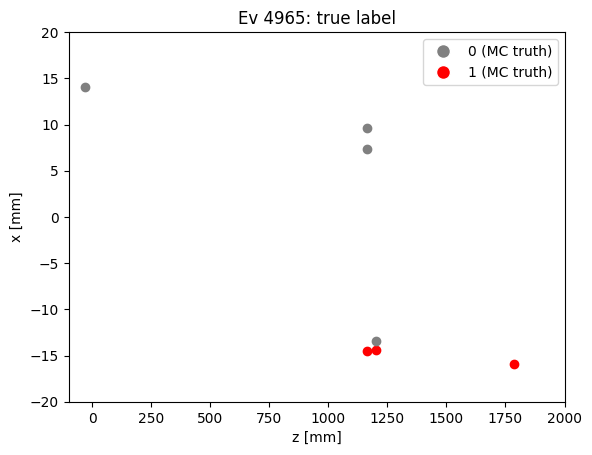

In [19]:
for i in range(len(x)):
    if label[i] == 0:
        plt.scatter(z_hit[i],x[i], color='grey', label='0')
    else:
        plt.scatter(z_hit[i],x[i], color='red', label='1')
plt.xlim(-100,2000)
plt.ylim(-20,20)
plt.xlabel('z [mm]')
if view=='xz':
    plt.ylabel('x [mm]')
else:
    plt.ylabel('y [mm]')
plt.title(f'Ev {ev_id}: true label')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='0 (MC truth)', markerfacecolor='grey', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1 (MC truth)', markerfacecolor='red', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')

# plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/2million_sageconv/true_label_view_{view}_ev_{ev_id}.png')

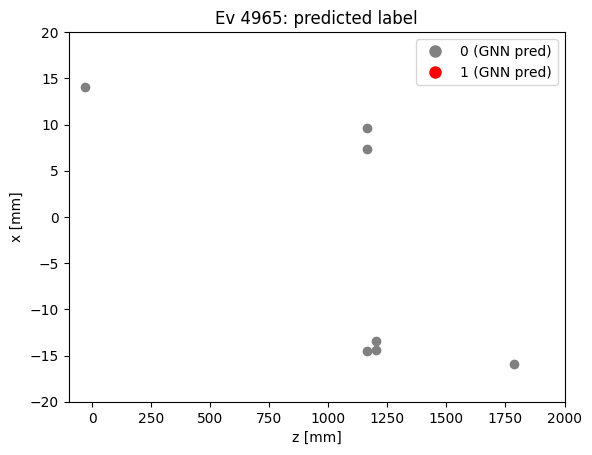

In [20]:
x_pred=[]
y_pred=[]
z_pred=[]
for i in range(len(x)):
    if label_pred[i] == 0:
        plt.scatter(z_hit[i],x[i], color='grey', label='0 (Pred)')
    else:
        x_pred.append(x[i].item())
        y_pred.append(ly[i].item())
        z_pred.append(z_hit[i].item())
        plt.scatter(z_hit[i],x[i], color='red', label='1 (Pred)')
        
plt.xlim(-100,2000)
plt.ylim(-20,20)
#plt.legend()
if view=='xz':
    plt.ylabel('x [mm]')
else:
    plt.ylabel('y [mm]')
plt.xlabel('z [mm]')
plt.title(f'Ev {ev_id}: predicted label')
legend_elements = [Line2D([0], [0], marker='o', color='w', label='0 (GNN pred)', markerfacecolor='grey', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='1 (GNN pred)', markerfacecolor='red', markersize=10)]

plt.legend(handles=legend_elements, loc='upper right')
# plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/2million_sageconv/pred_label_view_{view}_ev_{ev_id}.png')

In [13]:
best_model.to(device) 
test_loader=DataLoader(data_trk, batch_size=128,shuffle=True)

In [15]:
correct = 0
total_samples = 0
pred_test_cl=[]
targets=[]
prob=[]
# thrs=[0,0.1,0.15,0.2,0.25,0.3,0.35,0.40,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
thrs=[0.8]
# thrs=[0,0.1,0.5,0.55,0.6,0.7,0.75,0.9,0.95,3]
acc_list=[]
rec_list=[]
prec_list=[]
for th in thrs:
    tmpacc=0
    tmprec=0
    tmpprec=0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)  
            model_output = best_model(data)
            prob.extend(model_output.tolist())
            predicted_class =  torch.where(model_output > th, 1, 0)
            pred_test_cl.extend(predicted_class.tolist())
            correct += int((predicted_class == data.y).sum())
            targets.extend(data.y.tolist())
            total_samples += data.y.size(0)
            # print('len ',len(data), accuracy_score(data.y.tolist(),predicted_class.tolist()))
    
    tmpacc=accuracy_score(targets,pred_test_cl)
    tmprec=recall_score(targets,pred_test_cl)
    tmpprec=precision_score(targets,pred_test_cl)
    acc_list.append(round(tmpacc,2))
    rec_list.append(round(tmprec,2))
    prec_list.append(round(tmpprec,2))
    print(th,' accuracy ',tmpacc,' recall ', tmprec,' precision ',tmpprec)

0.8  accuracy  0.9761102599145248  recall  0.9648542027953556  precision  0.98510258462242


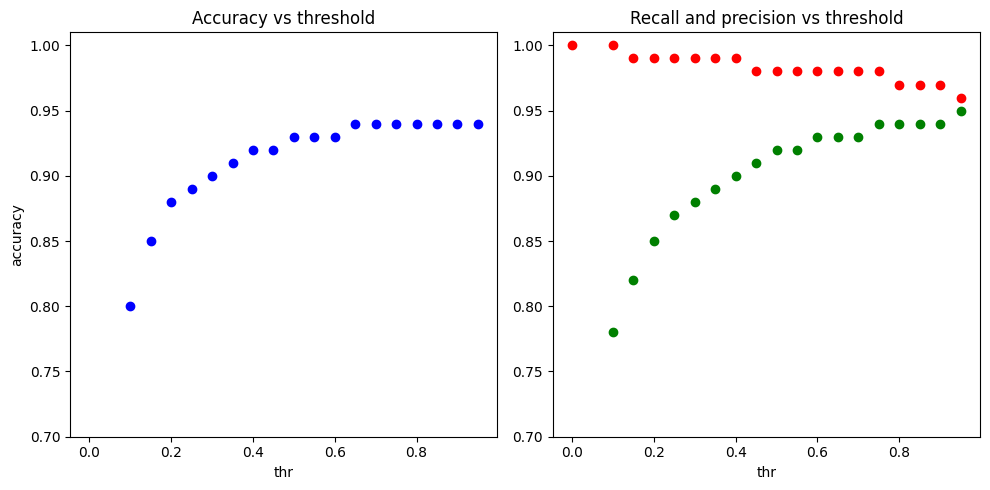

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title('Accuracy vs threshold')
axs[0].scatter(thrs,acc_list,color='b')
axs[0].set_xlabel('thr')
axs[0].set_ylabel('accuracy')
axs[0].set_ylim(0.7,1.01)
axs[1].set_title('Recall and precision vs threshold')
axs[1].scatter(thrs,rec_list,color='r',label='recall')
axs[1].scatter(thrs,prec_list,color='g',label='precision')
axs[1].set_xlabel('thr')
axs[1].set_ylim(0.7,1.01)
plt.tight_layout()

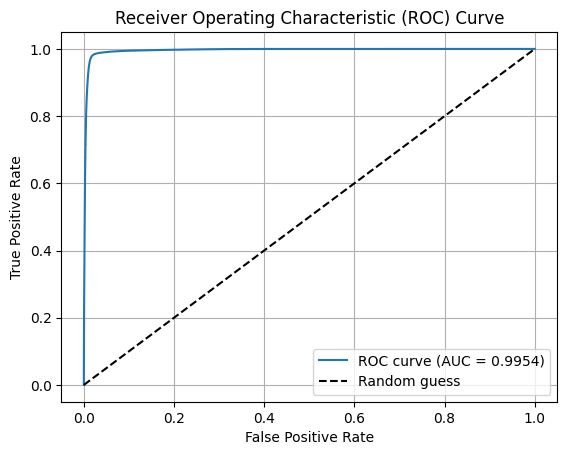

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calcola l'AUC
auc = roc_auc_score(targets, prob)

# Calcola i valori delle curve ROC
fpr, tpr, thresholds = roc_curve(targets, prob)

# Disegna la curva ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.grid(True)
plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/optimized_HNoise/ROC_curve_{model_list[sel_alg]}')
plt.show()

In [21]:
best_model.to(device) 
correct = 0
total_samples = 0
pred_test_cl=[]
targets=[]
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)  
        model_output = best_model(data)
        predicted_class =  torch.where(model_output > 0.8, 1, 0)
        pred_test_cl.extend(predicted_class.tolist())
        correct += int((predicted_class == data.y).sum())
        targets.extend(data.y.tolist())
        total_samples += data.y.size(0)

print('accuracy ',accuracy_score(targets,pred_test_cl),' recall ', recall_score(targets,pred_test_cl),' precision ',precision_score(targets,pred_test_cl))


accuracy  0.9602932636469221  recall  0.9537876364153425  precision  0.9874503165022818


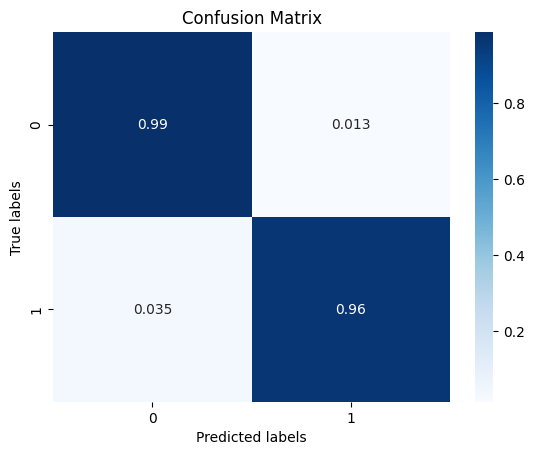

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di confusione
cm = confusion_matrix(targets, pred_test_cl,normalize='true')

# Plot della matrice di confusione
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/optimized_HNoise/conf_matrix_{model_list[sel_alg]}')
plt.show()

In [16]:
%%time
# gr=ROOT.TGraph(len(np.array(x_pred)),np.array(x_pred),np.array(z_pred))
# c1=ROOT.TCanvas()
# c1.cd()
# gr.GetXaxis().SetLimits(-20.0,20.0);
# gr.GetXaxis().SetTitle('x [mm]')
# gr.GetYaxis().SetTitle('z [mm]')
# gr.SetMarkerStyle(8)
# gr.Draw('AP')
myfile=ROOT.TFile('/lustrehome/federicacuna/TB_Sept_2023_ml/root_file_predhit/pred_data_xz_NORMBALANCED_SageConv.root','RECREATE')
# gr.Write()
# c1.Write()

test_batch_ev=[]
for ev_id in range(0,len(data_trk)):
    test_batch_ev.append(data_trk[ev_id])
    predicted_class_ev=[]
    
for i in test_batch_ev:
    i.to(device)
    model_output = best_model(i) 
    
    predicted_class_ev.append((torch.where(model_output > 0.8, 1, 0)))

         
ly_ev=[]
x_ev=[]
z_ev=[]
pe_ev=[]
dx_ev=[]
no_good_ev=[]
for i in range(len(test_batch_ev)): 
        
    ev=test_batch_ev[i]
    ev=ev.detach().cpu()
    label = predicted_class_ev[i].detach().cpu().numpy()
    ly_ev.append([])
    x_ev.append([])
    z_ev.append([])
    pe_ev.append([])
    dx_ev.append([])
    if all(el==0 for el in label):
        # print(i)
        no_good_ev.append(i)
        # print(label)
    for j,lab in enumerate(label):
        # print(j)
        # print(lab)
        if lab==1:
            if condition=='norm' or condition=='norm_balanced':
                # print('norm dataset')
                tmp_ly=ev.x[j,2].detach().cpu().tolist()
                tmp_ly=inverse_normalization_val(0, 3, 0, 1, tmp_ly)
                
                tmp_x=ev.x[j,0].detach().cpu().tolist()
                tmp_x=inverse_normalization_val(old_min_xhit, old_max_xhit, new_min, new_max, tmp_x)
                
                tmp_z=ev.x[j,3].detach().cpu().tolist() 
                tmp_z=inverse_normalization_val(old_min_z, old_max_z, new_min, new_max, tmp_z)
                
                tmp_dx=ev.x[j,1].detach().cpu().tolist() 
                tmp_dx=inverse_normalization_val(old_min_dx, old_max_dx, new_min, new_max, tmp_dx)
                
                tmp_pe=ev.x[j,4].detach().cpu().tolist()
                tmp_pe=inverse_normalization_val(old_min_PE, old_max_PE, new_min, new_max, tmp_pe)
                
            else:
                
                tmp_ly=ev.x[j,2].detach().cpu().tolist()
                tmp_x=ev.x[j,0].detach().cpu().tolist()
                tmp_z=ev.x[j,3].detach().cpu().tolist() 
                tmp_dx=ev.x[j,1].detach().cpu().tolist() 
                # print(tmp_dx)
                tmp_pe=ev.x[j,4].detach().cpu().tolist()        
                
            # print(tmp_pe)
            ly_ev[i].append(tmp_ly)
            x_ev[i].append(tmp_x)
            z_ev[i].append(tmp_z)
            dx_ev[i].append(tmp_dx)
            pe_ev[i].append(tmp_pe)


OutTree = ROOT.TTree("Reco_tree", "Reco_tree")   
ly_ev_vec = ROOT.std.vector("float")()
x_ev_vec = ROOT.std.vector("float")()
z_ev_vec = ROOT.std.vector("float")()
dx_ev_vec = ROOT.std.vector("float")()
pe_ev_vec = ROOT.std.vector("float")()
no_good_ev_vec=ROOT.std.vector("int")()
OutTree.Branch("ly_ev_vec", ly_ev_vec)
OutTree.Branch("x_ev_vec", x_ev_vec)
OutTree.Branch("z_ev_vec", z_ev_vec)
OutTree.Branch("dx_ev_vec", dx_ev_vec)
OutTree.Branch("pe_ev_vec", pe_ev_vec)
OutTree.Branch("no_good_ev_vec", no_good_ev_vec)
# print(x_ev)
for no_good in no_good_ev:
    no_good_ev_vec.push_back(no_good)
for l,x,z,dx,pe in zip(ly_ev,x_ev,z_ev,dx_ev,pe_ev):
    
    # Clear the contents of the vector
    ly_ev_vec.clear()
    x_ev_vec.clear()
    z_ev_vec.clear()
    dx_ev_vec.clear()
    pe_ev_vec.clear()
    
    # Replace the contents in the vector with the contents
    # from the current array
    ly_ev_vec.reserve(len(l))
    x_ev_vec.reserve(len(x))
    z_ev_vec.reserve(len(z))
    dx_ev_vec.reserve(len(dx))
    pe_ev_vec.reserve(len(pe))
    

    for il in l:
        ly_ev_vec.push_back(il)
    for ix in x:
        x_ev_vec.push_back(ix)
    for iz in z:
        z_ev_vec.push_back(iz)
    for idx in dx:
        dx_ev_vec.push_back(idx)
    for ipe in pe:
        pe_ev_vec.push_back(ipe)
        
        
    OutTree.Fill()

OutTree.Write()
myfile.Close()

CPU times: user 21.7 s, sys: 598 ms, total: 22.3 s
Wall time: 22.1 s


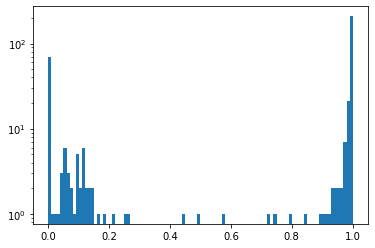

In [13]:
model=[]
for sublist in model_output.tolist():
    model+=sublist
plt.hist(model,bins=100,range=(0,1))
plt.yscale('log')
plt.show()

In [18]:
%%time
myfile=ROOT.TFile('/lustrehome/federicacuna/TB_Sept_2023_ml/root_file_predhit/pred_data_yz_NORMBALANCED_HN_SageConv.root','RECREATE')
test_batch_ev=[]
for ev_id in range(0,len(data_trk)):
    test_batch_ev.append(data_trk[ev_id])
    predicted_class_ev=[]
    
for i in test_batch_ev:
    i.to(device)
    model_output = best_model(i) 
    
    predicted_class_ev.append((torch.where(model_output > 0.8, 1, 0)))

         
ly_ev=[]
y_ev=[]
z_ev=[]
pe_ev=[]
dy_ev=[]
no_good_ev=[]
for i in range(len(test_batch_ev)): 
        
    ev=test_batch_ev[i]
    ev=ev.detach().cpu()
    label = predicted_class_ev[i].detach().cpu().numpy()
    ly_ev.append([])
    y_ev.append([])
    z_ev.append([])
    pe_ev.append([])
    dy_ev.append([])
    if all(el==0 for el in label):
        # print(i)
        no_good_ev.append(i)
        # print(label)
    for j,lab in enumerate(label):
        # print(j)
        # print(lab)
        if lab==1:
            if condition=='norm' or condition=='norm_balanced':
                tmp_ly=ev.x[j,2].detach().cpu().tolist()
                tmp_ly=inverse_normalization_val(0, 3, 0, 1, tmp_ly)
                
                tmp_y=ev.x[j,0].detach().cpu().tolist()
                tmp_y=inverse_normalization_val(old_min_yhit, old_max_yhit, new_min, new_max, tmp_y)
                
                tmp_z=ev.x[j,3].detach().cpu().tolist() 
                tmp_z=inverse_normalization_val(old_min_z, old_max_z, new_min, new_max, tmp_z)
                
                tmp_dy=ev.x[j,1].detach().cpu().tolist() 
                tmp_dy=inverse_normalization_val(old_min_dy, old_max_dy, new_min, new_max, tmp_dy)
                
                tmp_pe=ev.x[j,4].detach().cpu().tolist()
                tmp_pe=inverse_normalization_val(old_min_PE, old_max_PE, new_min, new_max, tmp_pe)
                
            else:
                
                tmp_ly=ev.x[j,2].detach().cpu().tolist()
                tmp_y=ev.x[j,0].detach().cpu().tolist()
                tmp_z=ev.x[j,3].detach().cpu().tolist() 
                tmp_dy=ev.x[j,1].detach().cpu().tolist() 
                # print(tmp_dx)
                tmp_pe=ev.x[j,4].detach().cpu().tolist()        
                
            # print(tmp_pe)
            ly_ev[i].append(tmp_ly)
            y_ev[i].append(tmp_y)
            z_ev[i].append(tmp_z)
            dy_ev[i].append(tmp_dy)
            pe_ev[i].append(tmp_pe)


OutTree = ROOT.TTree("Reco_tree", "Reco_tree")   
ly_ev_vec = ROOT.std.vector("float")()
y_ev_vec = ROOT.std.vector("float")()
z_ev_vec = ROOT.std.vector("float")()
dy_ev_vec = ROOT.std.vector("float")()
pe_ev_vec = ROOT.std.vector("float")()
no_good_ev_vec=ROOT.std.vector("int")()
OutTree.Branch("ly_ev_vec", ly_ev_vec)
OutTree.Branch("y_ev_vec", y_ev_vec)
OutTree.Branch("z_ev_vec", z_ev_vec)
OutTree.Branch("dy_ev_vec", dy_ev_vec)
OutTree.Branch("pe_ev_vec", pe_ev_vec)
OutTree.Branch("no_good_ev_vec", no_good_ev_vec)
# print(x_ev)
for no_good in no_good_ev:
    no_good_ev_vec.push_back(no_good)
for l,y,z,dy,pe in zip(ly_ev,y_ev,z_ev,dy_ev,pe_ev):
    
    # Clear the contents of the vector
    ly_ev_vec.clear()
    y_ev_vec.clear()
    z_ev_vec.clear()
    dy_ev_vec.clear()
    pe_ev_vec.clear()
    
    # Replace the contents in the vector with the contents
    # from the current array
    ly_ev_vec.reserve(len(l))
    y_ev_vec.reserve(len(y))
    z_ev_vec.reserve(len(z))
    dy_ev_vec.reserve(len(dy))
    pe_ev_vec.reserve(len(pe))
    

    for il in l:
        ly_ev_vec.push_back(il)
    for iy in y:
        y_ev_vec.push_back(iy)
    for iz in z:
        z_ev_vec.push_back(iz)
    for idy in dy:
        dy_ev_vec.push_back(idy)
    for ipe in pe:
        pe_ev_vec.push_back(ipe)
        
        
    OutTree.Fill()

OutTree.Write()
myfile.Close()

CPU times: user 23 s, sys: 489 ms, total: 23.5 s
Wall time: 23.4 s


In [ ]:
data=[]
for i in range(len(test_batch_ev)):
        data.append([i,x_ev[i],ly_ev[i],z_ev[i],dx_ev[i]])
            
df = pd.DataFrame(data, columns=['ev', 'x_hit', 'ly','z_hit','dx_hit'])

In [ ]:
df_explode=df.explode(['x_hit','ly','z_hit','dx_hit'])

In [ ]:
df_explode.head()

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(np.array(df_explode[df_explode.ev==2].x_hit).reshape(-1,1), np.array(df_explode[df_explode.ev==2].z_hit))

coeff=reg.coef_
intercept=reg.intercept_
x = np.linspace(-20, 20, 3)
y=coeff*x+intercept
plt.plot(x, y, color='red')
plt.scatter(df_explode[df_explode.ev==2].x_hit,df_explode[df_explode.ev==2].z_hit)
plt.ylim(-30,2000)

In [ ]:
 # chi2 += ROOT.TMath.Power((x_hit[i][j] - ax_ev[i] * z_hit[i][j]- bx_ev[i]) / dx_hit[i][j], 2);

In [ ]:
df

In [ ]:
df_explode